The following cell removes the output directory and it content, and creates it again empty.

In [ ]:
# Create empty content.   
if not os.path.exists('/content'):
    os.makedirs('/content')


# Return to content dir.
os.chdir('/content')

# Delete out and content.
try:
    shutil.rmtree("out/")
except OSError as e:
    print("Error: The directory do not exist.")

# Create empty out.   
if not os.path.exists('out'):
    os.makedirs('out')

# Change dir to out.
os.chdir('out')

print(os.getcwd())

/content/out


# **Import Libraries**
First step is importing all required libraries for the proyect.

In [ ]:
# Read and process csv files.
import pandas as pd
# Treat numbers.
import numpy as np
# Deal with directories and files.
import glob
# Creating and deleting directories
import os
import shutil
# Measure execution times.
import time
# Plot charts and graphics.
import matplotlib.pyplot as plt
# sklearn for cross-validation.
from sklearn.model_selection import KFold
# Statistics over lists.
import statistics 
# Keras for machine learning.
import keras
from keras import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import LSTM, Dense, Dropout, Input, Activation, Masking, Conv1D, Flatten

# **Parameters**
All the parameters used in the project has been collected here.

In [ ]:
#@markdown Path and extension of dataset files.
dataset_path = "drive/MyDrive/Datasets/KSAS-1/*.csv" #@param {type:"string"}


#@markdown Number of folds
num_folds = 10 #@param {type:"integer"}

#@markdown Apply or not EWMA to smooth curves.
ewma = True #@param {type:"boolean"}

#@markdown Apply or not normalization to set data in range .
norm = False #@param {type:"boolean"}

#@markdown Value of beta in EWMA.
ewma_b = 0.3 #@param {type:"number"}

#@markdown learning rate
adam_learning_rate = 0.0001 #@param {type:"number"}

#@markdown Columns to drop. Options: ["accelerometer_x", "accelerometer_y", "accelerometer_z", "gyros_x", "gyros_y", "gyros_z", "magn_field_x", "magn_field_y", "magn_field_z", "game_rot_vec_x", "game_rot_vec_y", "game_rot_vec_z"]
drop = [] #@param {type:"raw"}


#@markdown Which normalization method use: [std_mean, min_max]
chosen_norm = "min_max" #@param ["std_mean", "min_max"]

#@markdown Which model train. Options: [ann, rnn, cnn]
chosen_model = "rnn" #@param ["ann", "rnn", "cnn"]

#@markdown Parameters of Adam optimizer:
adam_beta_1 = 0.9 #@param {type:"number"}
adam_beta_2 = 0.999 #@param {type:"number"}
adam_decay = 0.0001 #@param {type:"number"}

#@markdown Model fit parameters:
model_loss = 'logcosh' #@param ["logcosh", "MeanSquaredError", "MeanAbsoluteError", "MeanAbsolutePercentageError", "MeanSquaredLogarithmicError", "CosineSimilarity", "Huber"]
model_validation_split = 0.3 #@param {type:"number"}
model_batch_size = 40 #@param {type:"integer"}
model_epochs = 1000 #@param {type:"integer"}

#@markdown Output directory:
output_dir = 'out/' #@param {type:"string"}

# **Load dataset**
The dataset is loaded here. It consist in a set of csv files, each one containing a movement of the execution of one participant. The name of the csv files follows the format a-b-c.csv, where:
*   **a**: number of movement.
*   **b**: id of participant.
*   **c**: 'i' or 'd' indicating if the execution has been made with the left or right arm respectively.

All the movements must be located in a folder named 'movements'.



In [ ]:
# Load files of dataset.
files = glob.glob("../" + dataset_path)
print(files)

# List for storing elements of the dataset.
X_raw = []
Y_raw = []

# Read files and store each example in list.
for path in files:
    df = pd.read_csv(path, sep=",", decimal=".", header=0)
    df = df.apply(pd.to_numeric)
    df = df.drop(drop, axis=1)
    
    # Convert df into list.
    X_raw.append(df.T.values.tolist())

    # Get class (movement) from file name.
    Y_raw.append(path.split("/")[5][0])

['../drive/MyDrive/Datasets/KSAS-1/2-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/3-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/4-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/5-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/1-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/2-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/3-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/4-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/5-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/1-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/2-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/3-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/4-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/5-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/1-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/3-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/4-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/5-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/2-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/3-19-d.csv', '../drive/MyDrive/Datasets/KSAS-1/4-19-d.csv', '../drive/My

After loading the dataset, we obtain two lists: X_raw and Y_raw. X_raw contains the signals measured for a movement, and Y_raw contains the class to which each element of X_raw belongs.

Let's print one of the movements and its class.

In [ ]:
print(X_raw[1][2])
print(Y_raw)
np.savetxt("raw.csv", X_raw[1][2], delimiter=",")

[-23.195, -21.491999999999997, -20.298, -15.397, -12.368, -10.01, -7.452999999999999, -7.053, -7.4270000000000005, -6.481, -5.959, -6.928999999999999, -8.037, -8.506, -9.962, -11.745999999999999, -13.437999999999999, -14.686, -16.362000000000002, -18.639, -19.673, -21.03, -26.448, -34.055, -35.637, -35.951, -35.094, -31.524, -31.057, -25.590999999999998, -17.801, -11.274000000000001, 1.5490000000000002, 4.7410000000000005, 8.655]
['2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '3', '4', '5', '2', '3', '4', '5', '1', '2', '1', '5', '4', '3', '2', '2', '1', '5', '4', '3', '3', '2', '1', '5', '4', '2', '1', '5', '4', '3', '2', '5', '4', '3', '1', '1', '5', '4', '3', '2', '1', '2', '3', '4', '5', '2', '1', '3', '4', '5', '5', '4', '1', '3', '2', '1', '4', '3', '2', '4', '3', '1', '5', '2', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '4', '3', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', 

# **Normalization**

As a way to speed up learnig, we are going to normalize the dataset. This will make each attribute to have a mean closer to 0. The normalization is done by attribute and not globally.

In [ ]:
if(norm):
  X_norm = []
  for example in X_raw:
    resExample = []
    for attribute in example:
      if chosen_norm == "std_mean":
        resExample.append((attribute - np.mean(example)) / np.std(attribute))
      elif chosen_norm == "min_max":
        resExample.append((attribute - np.min(example)) / (np.max(example) - np.min(example)))
    X_norm.append(resExample.copy())
else:
  X_norm = X_raw

Now we have the dataset normalized.

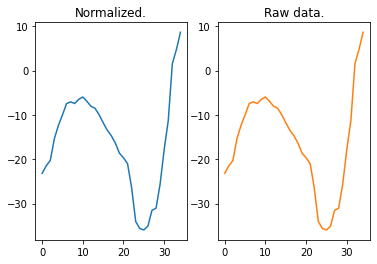

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(X_norm[1][2], 'tab:blue')
ax1.set_title("Normalized.")
ax2.plot(X_raw[1][2], 'tab:orange')
ax2.set_title("Raw data.")
plt.show()
# np.savetxt("norm.csv", X_norm[1][2], delimiter=",")

# **Smooth the curves**
The curves genedated by the attributes in each sample are so sharp and noisy. We can smooth this curves using Exponentially Weighted Moving Averages. Let's define a function to smooth this curves.

In [ ]:
def applyEWMA(beta, dataset):
    pos = 0
    resX = []
    for example in dataset:
        resExample = []
        for attribute in example:
            resAttribute = [attribute[0]]
            for value in attribute:
                resValue = (beta * value) + (1-beta) * resAttribute[pos]
                resAttribute.append(resValue)
                pos += 1
            resAttribute.pop(0)
            resExample.append(resAttribute.copy())
            resAttribute.clear()
            pos = 0
        resX.append(resExample.copy())
        resExample.clear()
    return resX

Now, we can use this function to apply EWMA over the full dataset.

In [ ]:
if(ewma):
    X_smooth = applyEWMA(ewma_b, X_norm)

Let's take a look of how we have smoothen our curves.

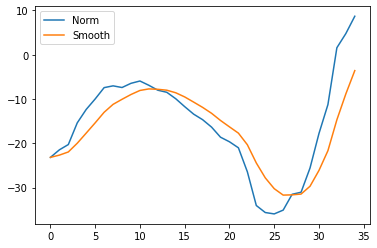

In [ ]:
if(ewma):
  plt.plot(X_norm[1][2], label='Norm')
  plt.plot(X_smooth[1][2], label='Smooth')
  plt.legend()
  plt.show()
  np.savetxt("smooth2.csv", X_smooth[1][2], delimiter=",")

By adjusting the value of beta, we can control how smooth the new curves are. Lower values of beta gives smoother curves. If beta is 1, the generated curve is the same as the original.

# **Padding the sequences**
For feeding the neural networks, all sequences must have the same length. Here, the length of the longest sequence is obtained, so all the sequences can be expanded (padded) till reach the length of the longest sequence in the dataset.

In [ ]:
maxLength = 0
for example in X_smooth:
  if len(example[0]) > maxLength:
    maxLength = len(example[0])
print("Length of longest sample: " + str(maxLength))

Length of longest sample: 56


Now, we are going to expand each sample.

In [ ]:
# Extend each sample to maximum length
X_expanded = []
for example in X_smooth:
  resExample = pad_sequences(example, padding='post', maxlen=maxLength, dtype='float64')
  X_expanded.append(resExample)

Let's see an example of expanded movement.

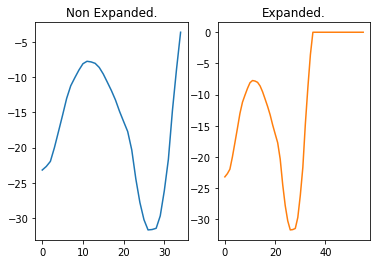

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(X_smooth[1][2], 'tab:blue')
ax1.set_title("Non Expanded.")
ax2.plot(X_expanded[1][2], 'tab:orange')
ax2.set_title("Expanded.")
plt.show()
# np.savetxt("pad.csv", X_expanded[1][2], delimiter=",")

# **Convert to ndarray**

Right now, we have a list of examples, where each one is a ndarray containing 18 attributes. Each attribute has the length of the previously calculated max length. We should turn that list in an ndarray, resulting in a 3-dimensional ndarray. The output Y should be formed by one-hot vectors, so we will use the function to_categorical to turn each output in a one-hot vector.

In [ ]:
# Convert into Array
X = np.asarray(X_expanded)
print(X.shape)
Y = np.asarray(Y_raw)
print(Y.shape)
Y = to_categorical(Y)
print(Y.shape)

(240, 18, 56)
(240,)
(240, 6)


As input dataset for trainig, we are going to use the smoothen and normalized dataset X_norm. Let's get its dimensions.

In [ ]:
# Get dimensions
num_examples, num_attributes, num_values = X.shape
print(X.shape)
_, num_classes = Y.shape
print("Num. Examples: " + str(num_examples))
print("Num. Attributes: " + str(num_attributes))
print("Num. Values: " + str(num_values))
print("Num. Classes: " + str(num_classes))


(240, 18, 56)
Num. Examples: 240
Num. Attributes: 18
Num. Values: 56
Num. Classes: 6


# **Create the model**

Now we are going to create three models with the following characteristics: 

*   The first model is using a Conv1D layer. After that, dropout is applied for preventing overfitting, and the data is flattened into a one-dimensional array. Then, that array is passed to a dense layer with 6 units (number of classes), and softmax is applied.
*   The second model is using a Dense layer. After that, dropout is applied for preventing overfitting. Then, the output of the dense layer is passed to another dense layer with 6 units (number of classes), and softmax is applied.
*   The third model is using a LSTM layer. After that, dropout is applied for preventing overfitting, and the data is flattened into a one-dimensional array. Then, that array is passed to a dense layer with 6 units (number of classes), and softmax is applied.

In the three cases below, the value for dropout is 0.5. Those are very simple models, but in the training set used with a good configuration of parameters, achieved accuracies over 0.9 for the training set and over 0.8 in the test set. LSTM is the model that got the better results with 1.0 of accuracy over the training set and 0.94 over the test set.

In [ ]:
# Build CNN model.
def cnn_model(input_shape):
  
    input = Input(shape=input_shape, dtype='float32')
    i = Conv1D(filters=32, kernel_size=5, activation='relu')(input)
    i = Dropout(0.5)(i)
    i = Flatten()(i)

    i = Dense(num_classes)(i)
    i = Activation('softmax')(i)

    model = Model(inputs=input, outputs=i)

    return model

In [ ]:
# Build ANN model.
def ann_model(input_shape):
  
    input = Input(shape=input_shape, dtype='float32')
    i = Flatten()(input)

    i = Dense(512)(i)
    i = Dropout(0.5)(i)
    i = Dense(num_classes)(i)
    i = Activation('softmax')(i)

    model = Model(inputs=input, outputs=i)

    return model

In [ ]:
# Build RNN model.
def rnn_model(input_shape):

    input = Input(shape=input_shape, dtype='float32')
    #i = Masking(mask_value=0.0)(input)
    i = LSTM(56, return_sequences=True)(input)
    i = Dropout(0.5)(i)
    i = Flatten()(i)

    i = Dense(num_classes)(i)
    i = Activation('softmax')(i)

    model = Model(inputs=input, outputs=i)

    return model

Let's create a function that instantiates the model and print the summary.

In [ ]:
def create_model():
  if chosen_model == "rnn":
    model = rnn_model(input_shape=(num_attributes, num_values))
  elif chosen_model == "cnn":
    model = cnn_model(input_shape=(num_attributes, num_values))
  elif chosen_model == "ann":
    model = ann_model(input_shape=(num_attributes, num_values))
    
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  return model

# **Training the model**

Now let's train the model using an Adam optimizer.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_________________________________________________________

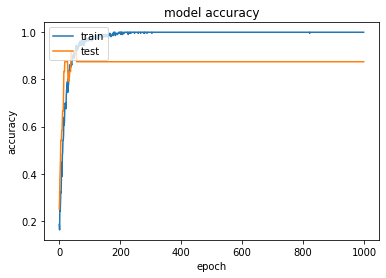

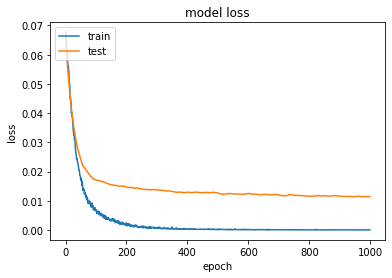

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

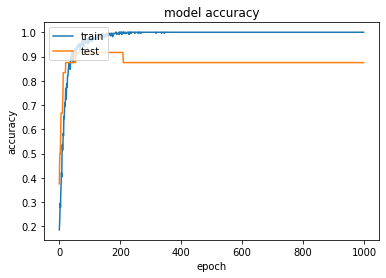

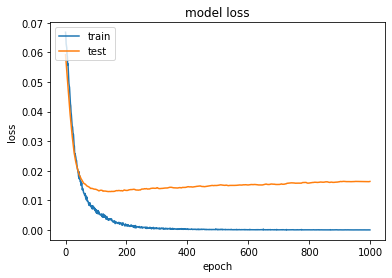

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

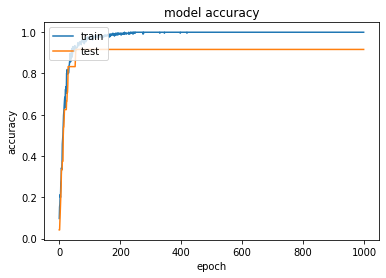

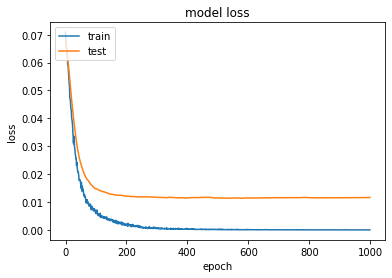

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

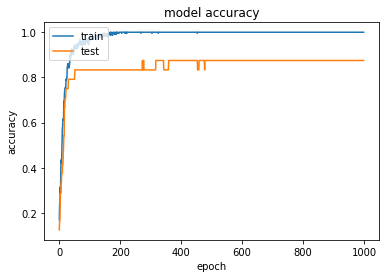

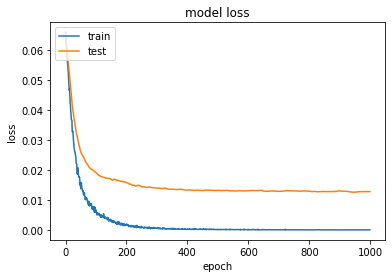

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

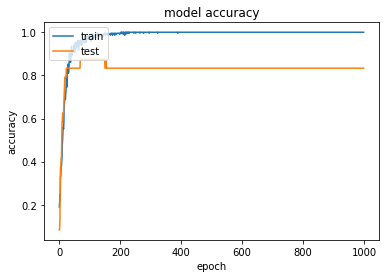

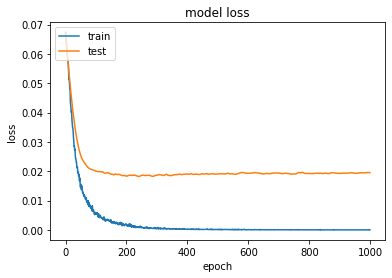

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

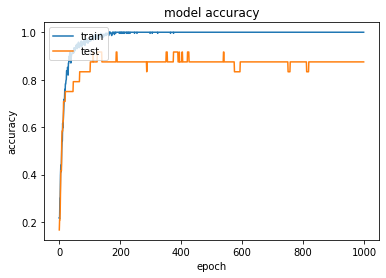

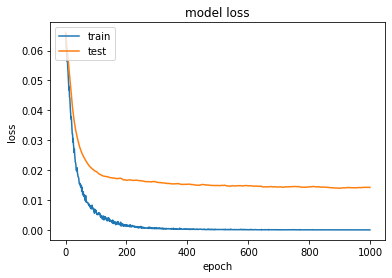

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

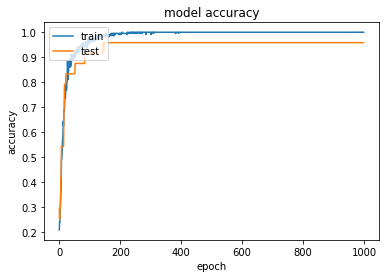

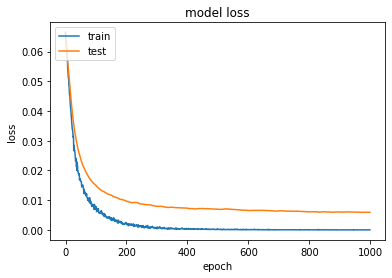

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

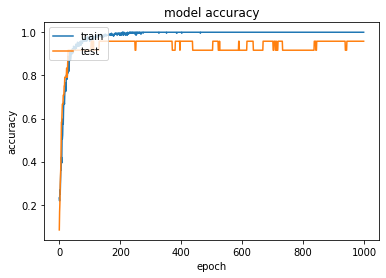

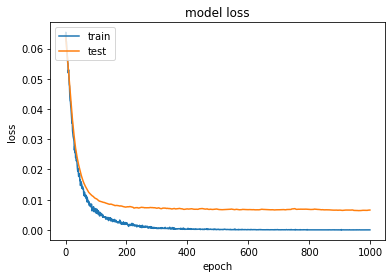

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

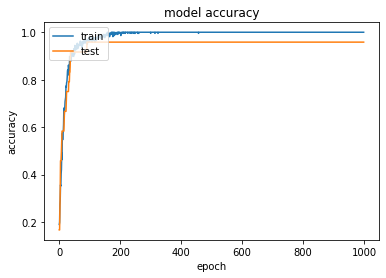

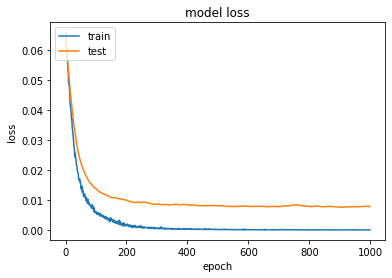

Saved model to disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 56)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 56)            25312     
_________________________________________________________________
dropout (Dropout)            (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6054      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 31,366
Trainable params: 31,366
Non-trainable params: 0
_____________________________________

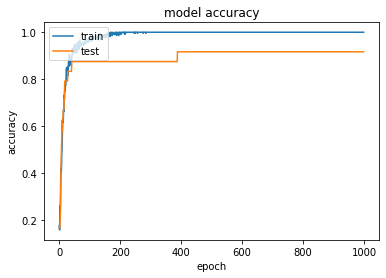

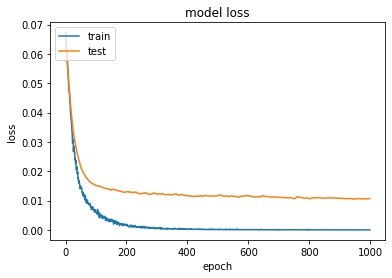

Saved model to disk
Mean accuracy training: 1.0
Mean accuracy validation: 0.9041666626930237
Mean time: 80.09961848258972


In [ ]:
# Initialize kfolds.
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define per-fold score containers
acc_per_fold = []
val_acc_per_fold = []
time_per_fold = []

# Iterate over folds.
fold_no = 1

# Create directory.
output_dir = chosen_model + "/norm-" + str(norm) + "/ewma-" + str(ewma_b) + "/lr-" + str(adam_learning_rate) + "/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    os.chdir(output_dir)

for train, test in kfold.split(X, Y):

  model = create_model()

  # Instantiate optimizer and compile selected model.
  opt = Adam(learning_rate=adam_learning_rate, beta_1=adam_beta_1, beta_2=adam_beta_2, decay=adam_decay)
  model.compile(loss=model_loss, optimizer=opt, metrics=["accuracy"])

  # Get timestamp.
  start_time = time.time()

  # Start training. Set verbose to 1 or 2 to print progress.
  history = model.fit(X[train], Y[train],
                      batch_size=model_batch_size, 
                      epochs=model_epochs, verbose=0
                      ,validation_data=(X[test], Y[test]),)

  print(history.history.keys())
  
  total_time = (time.time() - start_time)

  # Print accuracies and time.
  print("---------------------------------------------------------")
  print("Fold " + str(fold_no))
  print("Train acc.: %s" % history.history['accuracy'][-1])
  print("Test acc.: %s" % history.history['val_accuracy'][-1])
  print("Time: %s" % total_time)

  # Save accuracies and time into a file.
  f = open("results" + str(fold_no) + ".txt", "w")
  f.write("Train acc.: " + str(history.history['accuracy'][-1]) + "\n")
  f.write("Test acc.: " + str(history.history['val_accuracy'][-1]) + "\n")
  f.write("Time: " + str(total_time) + "\n")
  f.close()

  # Show data saved in history,
  print(history.history.keys())

  # Show accuracy and save chart into file.
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('Accuracy-fold-' + str(fold_no) + '.png')
  plt.show()

  # Show loss and save chart into file.
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('Loss-fold-' + str(fold_no) + '.png')
  plt.show()

  fold_no = fold_no + 1
  keras.backend.clear_session()

  acc_per_fold.append(history.history['accuracy'][-1])
  val_acc_per_fold.append(history.history['val_accuracy'][-1])
  time_per_fold.append(total_time)

  # Save model to JSON file.
  model_json = model.to_json()
  with open("model" + str(fold_no) + ".json", "w") as json_file:
      json_file.write(model_json)
      
  # Save weights to HDF5 file.
  model.save_weights("model" + str(fold_no) + ".h5")

  # Convert history into pandas df.
  hist_df = pd.DataFrame(history.history)
  # Save history into JSON file.
  hist_json_file = "history" + str(fold_no) + ".json" 
  with open(hist_json_file, mode='w') as f:
      hist_df.to_json(f)
  # Save history into CSV file.
  hist_csv_file = "history" + str(fold_no) + ".csv"
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)
      
  print("Saved model to disk")


print("Mean accuracy training: " + str(statistics.mean(acc_per_fold)))
print("Mean accuracy validation: " + str(statistics.mean(val_acc_per_fold)))
print("Mean time: " + str(statistics.mean(time_per_fold)))

# Save statistics into a file.
f = open("averages.txt", "w")
f.write("Mean train acc.: " + str(statistics.mean(acc_per_fold)) + "\n")
f.write("Mean test acc.: " + str(statistics.mean(val_acc_per_fold)) + "\n")
f.write("Time: " + str(statistics.mean(time_per_fold)) + "\n")
f.close()

# **Download as zip**

Download results and generated files as zip.


In [ ]:
# Create zip
!zip -r /content/out.zip /content/out

# Download
from google.colab import files
files.download("/content/out.zip")

updating: content/out/ (stored 0%)
updating: content/out/raw.csv (deflated 72%)
updating: content/out/smooth2.csv (deflated 58%)
updating: content/out/rnn/ (stored 0%)
updating: content/out/rnn/norm-False/ (stored 0%)
updating: content/out/rnn/norm-False/ewma-0.3/ (stored 0%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/ (stored 0%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/Accuracy-fold-9.png (deflated 7%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/results1.txt (deflated 7%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/history5.csv (deflated 64%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/model10.h5 (deflated 18%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/history4.csv (deflated 68%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/model_plot.png (deflated 18%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/model9.json (deflated 73%)
updating: content/out/rnn/norm-False/ewma-0.3/lr-0.0001/model1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>